In [ ]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

from google.colab import drive
drive.mount('/content/drive/')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Mounted at /content/drive/


# Keras LSTM


In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from tensorflow.keras import activations
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, BatchNormalization
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

## Data: sentiment and tweets

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Tilburg/vaccination_tweet_sentiment.csv").dropna(subset = ['text'])

ref = np.array([False if len(str(data.iloc[i,10])) < 3 else True for i in range(len(data))])

data = data[ref].reset_index()
data['index'] = None

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
label = pd.read_csv("/content/drive/MyDrive/Tilburg/trends.csv")

label['Daily Count People Receiving Dose 1'] = label['Daily Count People Receiving Dose 1']

label = label.drop(columns = ['Date Type', 'Location'])

label.columns = ['date', 'count']

In [ ]:
y = []
m = []
d = []
for i in range(len(data)):
    try:
        string = str(data['date'][i]).split('-')
        y.append(string[0])

        ms = string[1]
        ms = str(int(ms))  
        m.append(ms)

        ds = string[2].split(' ')[0]
        ds = str(int(ds))
        d.append(ds)

        if i % 20000 == 0:
            print('{0} has done'.format(i))
    except:
        print(i)
        raise ValueError

data['y'] = np.array(y)
data['m'] = np.array(m)
data['d'] = np.array(d)

data['user_followers'] = data['user_followers'].astype('float64')

In [ ]:
date = []
index = []
userfollowers = []

s = 0

for y_ in ['2021']:
    for m_ in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']:
        for d_ in  ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']:

            subset = data[(data['y'] == y_) & (data['m'] == m_) & (data['d'] == d_)]
            day = '{0}/{1}/{2}'.format(y_, m_, d_)

            if subset.shape[0] != 0:

                neu = subset[data['sentiment'] == 'neutral'].shape[0]
                pos = subset[data['sentiment'] == 'positive'].shape[0]
                neg = subset[data['sentiment'] == 'negative'].shape[0]

                date.append(day)
                index.append(pos/(neu+neg))
                userfollowers.append(subset['user_followers'].sum())
                s+=1

            else:
                date.append(day)
                index.append(0)
                userfollowers.append(0)
                
            # print(day)

seq_data = pd.DataFrame({'date':date, 'index':index, 'user_followers':userfollowers})
print(s)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


299


In [ ]:
seq_data.index = seq_data['date']
label.index = label['date']

# seq_data = seq_data.reset_index(drop = True)
# label = label.reset_index(drop = True)

In [ ]:
seq_label = pd.concat([seq_data, label['count']], axis = 1).dropna()
seq_label.head()

,date,index,user_followers,count
2021/1/1,2021/1/1,0.158537,13994585.0,71298.0
2021/1/2,2021/1/2,0.238806,2628859.0,251197.0
2021/1/3,2021/1/3,0.076923,1723342.0,128820.0
2021/1/4,2021/1/4,0.125000,2763041.0,589246.0
2021/1/5,2021/1/5,0.180851,5280200.0,721026.0


In [ ]:
part_seq_label = seq_label[seq_label['index'] != 0].reset_index(drop = True)

# select period window
part_seq_label = part_seq_label.iloc[58:218,:].reset_index(drop = True)

part_seq_label['count-1'] = part_seq_label['count'].shift(1)
part_seq_label = part_seq_label.dropna().reset_index(drop = True)
part_seq_label.head()

,date,index,user_followers,count,count-1
0,2021/3/1,0.172372,350625750.0,1181439.0,542599.0
1,2021/3/2,0.173497,93486506.0,1474886.0,1181439.0
2,2021/3/3,0.174216,292038353.0,1750078.0,1474886.0
3,2021/3/4,0.153409,204847218.0,1969786.0,1750078.0
4,2021/3/5,0.196193,124212969.0,2020347.0,1969786.0


In [ ]:
part_seq_label['y'] = part_seq_label['count']
part_seq_label = part_seq_label.drop(['count'], axis = 1) 
part_seq_label.head()

,date,index,user_followers,count-1,y
0,2021/3/1,0.172372,350625750.0,542599.0,1181439.0
1,2021/3/2,0.173497,93486506.0,1181439.0,1474886.0
2,2021/3/3,0.174216,292038353.0,1474886.0,1750078.0
3,2021/3/4,0.153409,204847218.0,1750078.0,1969786.0
4,2021/3/5,0.196193,124212969.0,1969786.0,2020347.0


## minmax scaler

In [ ]:
# min-max scaler
seq_label_np = np.array(part_seq_label[['index', 'user_followers', 'count-1', 'y']])

for i in [0,1,2,3]:
    minimum = seq_label_np[:,i].min()
    maximum = seq_label_np[:,i].max()

    seq_label_np[:,i] = (seq_label_np[:,i] - minimum) / (maximum - minimum)

seq_label_np.shape

(159, 4)

## create sequence structure

In [ ]:
def create_sequences(data, seq_length, y_index):
    xs = []
    ys = []

    for i in range(len(data)-seq_length+1):
        x = data[i:(i+seq_length), :y_index]
        y = data[i:(i+seq_length), y_index]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [ ]:
seq_length = 7
sep = seq_label_np.shape[0] + 1 - seq_length - 31

X, y = create_sequences(seq_label_np, seq_length, 3)

X_trainval = X[:sep,:,:]
X_test = X[sep:,:,:]
y_trainval = y[:sep,:]
y_test = y[sep:,:]


## seperate train, val and test

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

y_train = y_train[:,:,None]
y_val = y_val[:,:,None]
y_test = y_test[:,:,None]

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(108, 7, 3)
(20, 7, 3)
(25, 7, 3)
(108, 7, 1)
(20, 7, 1)
(25, 7, 1)


In [ ]:
y_train = y_train[:,-1,:]
y_val = y_val[:,-1,:]
y_test = y_test[:,-1,:]

In [ ]:
X_train_1 = X_train[:,:,-1]
X_val_1 = X_val[:,:,-1]
X_test_1 = X_test[:,:,-1]


In [ ]:
print(X_train_1.shape)
print(X_val_1.shape)
print(X_test_1.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(108, 7, 1)
(20, 7, 1)
(25, 7, 1)
(108, 1)
(20, 1)
(25, 1)


In [ ]:
X_train_1 = X_train_1[:,:,None]
X_val_1 = X_val_1[:,:,None]
X_test_1 = X_test_1[:,:,None]

## sequence = 6, 7, 10, 12, 14

### seq = 6

In [ ]:
X, y = create_sequences(seq_label_np, 6, 3)

X_trainval = X[:128,:,:]
X_test = X[128:,:,:]
y_trainval = y[:128,:]
y_test = y[128:,:]

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

y_train = y_train[:,:,None]
y_val = y_val[:,:,None]
y_test = y_test[:,:,None]

y_train = y_train[:,-1,:]
y_val = y_val[:,-1,:]
y_test = y_test[:,-1,:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_val, y_val), callbacks=[callback])

pre_test = model.predict(X_test)

([<matplotlib.axis.XTick at 0x7f159c973fd0>,
 <a list of 33 Text major ticklabel objects>)

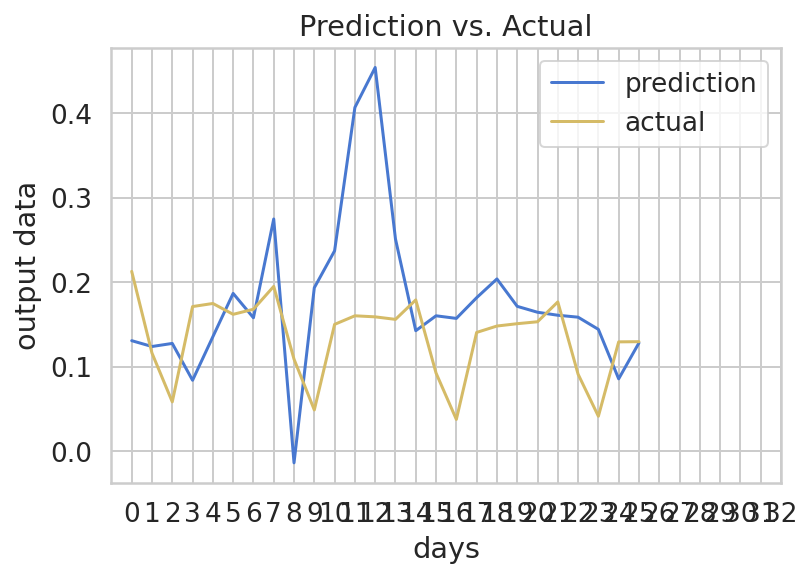

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pre_test, 'b-', label = 'prediction')
plt.plot(y_test, 'y-', label = 'actual')

plt.xlabel('days')
plt.ylabel('output data')
plt.title('Prediction vs. Actual')
plt.legend()
plt.xlim(-1,18,)
plt.xticks(np.linspace(0,32,33))

In [ ]:
RMSE = round(rmse(pre_test, y_test), 4)
MAE = round(mae(pre_test, y_test), 4)
MDA = round(mda(pre_test, y_test), 4)
print('The RMSE for model with seq = 6 is {0}'.format(RMSE))
print('The MAE for model with seq = 6 is {0}'.format(MAE))
print('The MDA for model with seq = 6 is {0}%'.format(MDA*100))

The RMSE for model with seq = 6 is 0.076
The MAE for model with seq = 6 is 0.0541
The MDA for model with seq = 6 is 32.0%


### seq = 7

In [ ]:
seq_length = 7
sep = seq_label_np.shape[0] + 1 - seq_length - 31

X7, y7 = create_sequences(seq_label_np, seq_length, 3)

X7_trainval = X7[:sep,:,:]
X7_test = X7[sep:,:,:]
y7_trainval = y7[:sep,:]
y7_test = y7[sep:,:]


X7_train, X7_val, y7_train, y7_val = train_test_split(X7_trainval, y7_trainval, test_size=0.15, random_state=42)

y7_train = y7_train[:,:,None]
y7_val = y7_val[:,:,None]
y7_test = y7_test[:,:,None]

y7_train = y7_train[:,-1,:]
y7_val = y7_val[:,-1,:]
y7_test = y7_test[:,-1,:]

print(X7_train.shape)
print(X7_val.shape)
print(X7_test.shape)
print(y7_train.shape)
print(y7_val.shape)
print(y7_test.shape)

model7 = buildManyToOneModel(X7_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model7.fit(X7_train, y7_train, epochs=1000, batch_size=128, validation_data=(X7_val, y7_val), callbacks=[callback])

pre_test7 = model7.predict(X7_test)


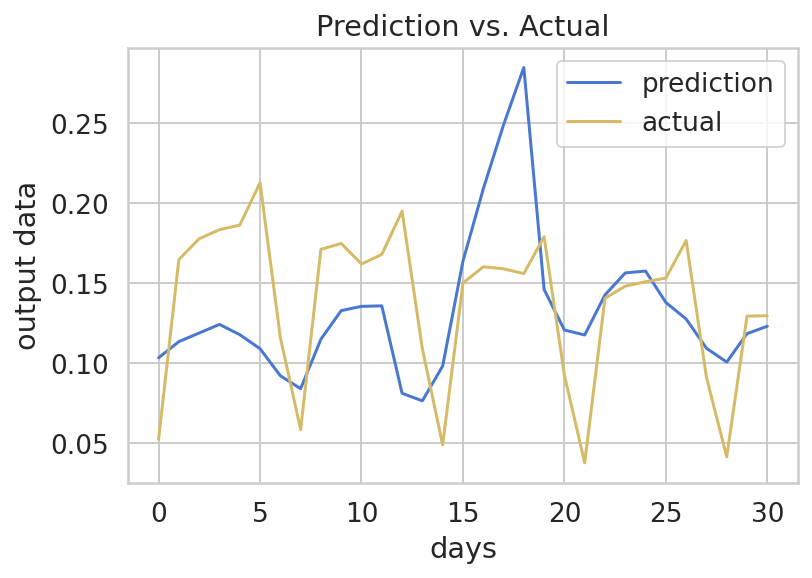

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pre_test7, 'b-', label = 'prediction')
plt.plot(y7_test, 'y-', label = 'actual')

plt.xlabel('days')
plt.ylabel('output data')
plt.title('Prediction vs. Actual')
plt.legend()


In [ ]:
RMSE = round(rmse(pre_test7, y7_test), 4)
MAE = round(mae(pre_test7, y7_test), 4)
MDA = round(mda(pre_test7, y7_test), 4)
print('The RMSE for model with seq = 7 is {0}'.format(RMSE))
print('The MAE for model with seq = 7 is {0}'.format(MAE))
print('The MDA for model with seq = 7 is {0}%'.format(MDA*100))

The RMSE for model with seq = 7 is 0.0551
The MAE for model with seq = 7 is 0.0449
The MDA for model with seq = 7 is 66.67%


### seq = 10 

In [ ]:
X, y = create_sequences(seq_label_np, 10, 3)

X_trainval = X[:128,:,:]
X_test = X[128:,:,:]
y_trainval = y[:128,:]
y_test = y[128:,:]

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

y_train = y_train[:,:,None]
y_val = y_val[:,:,None]
y_test = y_test[:,:,None]

y_train = y_train[:,-1,:]
y_val = y_val[:,-1,:]
y_test = y_test[:,-1,:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_val, y_val), callbacks=[callback])

pre_test = model.predict(X_test)


([<matplotlib.axis.XTick at 0x7f159d481fd0>,
 <a list of 18 Text major ticklabel objects>)

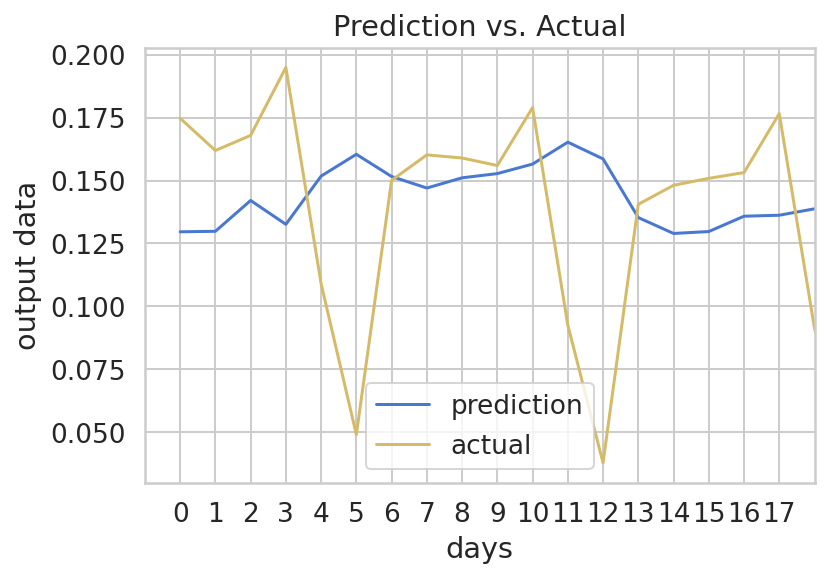

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pre_test, 'b-', label = 'prediction')
plt.plot(y_test, 'y-', label = 'actual')

plt.xlabel('days')
plt.ylabel('output data')
plt.title('Prediction vs. Actual')
plt.legend()
plt.xlim(-1,18,)
plt.xticks(np.linspace(0,17,18))

In [ ]:
RMSE = round(rmse(pre_test, y_test), 4)
MAE = round(mae(pre_test, y_test), 4)
MDA = round(mda(pre_test, y_test), 4)
print('The RMSE for model with seq = 6 is {0}'.format(RMSE))
print('The MAE for model with seq = 6 is {0}'.format(MAE))
print('The MDA for model with seq = 6 is {0}%'.format(MDA*100))

The RMSE for model with seq = 6 is 0.0503
The MAE for model with seq = 6 is 0.0377
The MDA for model with seq = 6 is 33.33%


### seq = 12

In [ ]:
seq_length = 12
sep = seq_label_np.shape[0] + 1 - seq_length - 31

X, y = create_sequences(seq_label_np, seq_length, 3)

X_trainval = X[:sep,:,:]
X_test = X[sep:,:,:]
y_trainval = y[:sep,:]
y_test = y[sep:,:]


X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

y_train = y_train[:,:,None]
y_val = y_val[:,:,None]
y_test = y_test[:,:,None]

y_train = y_train[:,-1,:]
y_val = y_val[:,-1,:]
y_test = y_test[:,-1,:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_val, y_val), callbacks=[callback])

pre_test = model.predict(X_test)

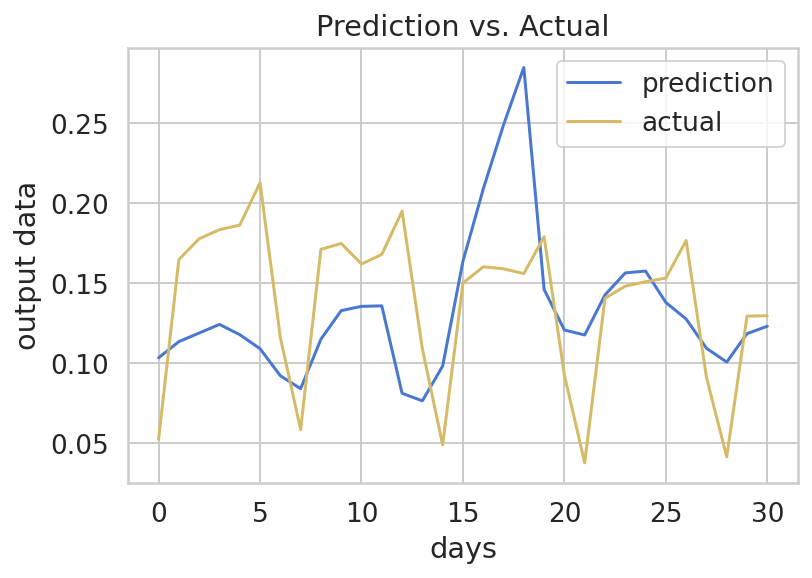

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pre_test7, 'b-', label = 'prediction')
plt.plot(y7_test, 'y-', label = 'actual')

plt.xlabel('days')
plt.ylabel('output data')
plt.title('Prediction vs. Actual')
plt.legend()


In [ ]:
RMSE = round(rmse(pre_test, y_test), 4)
MAE = round(mae(pre_test, y_test), 4)
MDA = round(mda(pre_test, y_test), 4)
print('The RMSE for model with seq = 6 is {0}'.format(RMSE))
print('The MAE for model with seq = 6 is {0}'.format(MAE))
print('The MDA for model with seq = 6 is {0}%'.format(MDA*100))

The RMSE for model with seq = 6 is 0.1077
The MAE for model with seq = 6 is 0.0872
The MDA for model with seq = 6 is 36.67%


### seq = 14

In [ ]:
seq_length = 14
sep = seq_label_np.shape[0] + 1 - seq_length - 31

X7, y7 = create_sequences(seq_label_np, seq_length, 3)

X7_trainval = X7[:sep,:,:]
X7_test = X7[sep:,:,:]
y7_trainval = y7[:sep,:]
y7_test = y7[sep:,:]


X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

y_train = y_train[:,:,None]
y_val = y_val[:,:,None]
y_test = y_test[:,:,None]

y_train = y_train[:,-1,:]
y_val = y_val[:,-1,:]
y_test = y_test[:,-1,:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_val, y_val), callbacks=[callback])

pre_test = model.predict(X_test)

([<matplotlib.axis.XTick at 0x7f159ddffbd0>,
 <a list of 18 Text major ticklabel objects>)

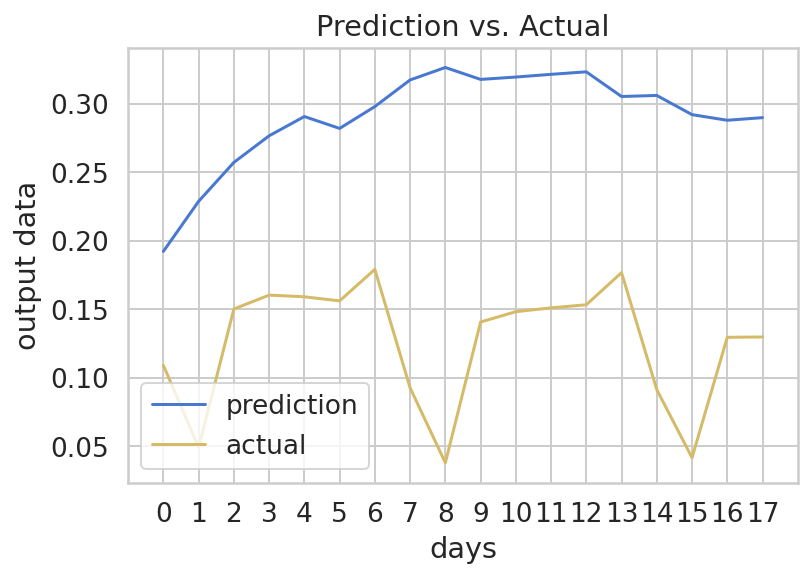

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pre_test, 'b-', label = 'prediction')
plt.plot(y_test, 'y-', label = 'actual')

plt.xlabel('days')
plt.ylabel('output data')
plt.title('Prediction vs. Actual')
plt.legend()
plt.xlim(-1,18,)
plt.xticks(np.linspace(0,17,18))

In [ ]:
RMSE = round(rmse(pre_test, y_test), 4)
MAE = round(mae(pre_test, y_test), 4)
MDA = round(mda(pre_test, y_test), 4)
print('The RMSE for model with seq = 6 is {0}'.format(RMSE))
print('The MAE for model with seq = 6 is {0}'.format(MAE))
print('The MDA for model with seq = 6 is {0}%'.format(MDA*100))

The RMSE for model with seq = 6 is 0.1732
The MAE for model with seq = 6 is 0.1654
The MDA for model with seq = 6 is 52.94%


## Model

In [ ]:
def mda(actual: np.ndarray, predicted: np.ndarray):
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

def mse(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.square(actual - predicted))

def mae(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.abs(actual - predicted))

def rmse(actual: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mse(actual, predicted))

In [ ]:
def buildManyToOneModel(shape):
    model = Sequential()  # 别改
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
    # output shape: (1, 1)
    model.add(Dense(10))
    model.add(Dense(5))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam", metrics = ['mean_squared_error']) # 别改
    model.summary()
    return model

In [ ]:
model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_val, y_val), callbacks=[callback])


In [ ]:
pre_test = model.predict(X_test)

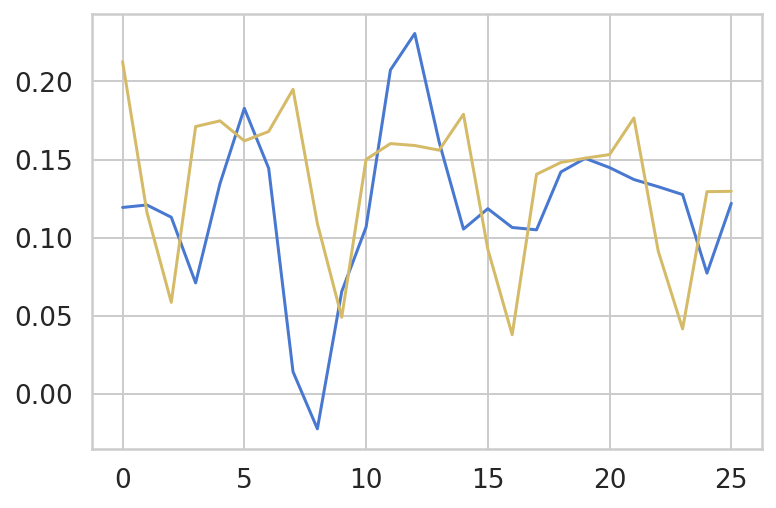

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pre_test, 'b-')
plt.plot(y_test, 'y-')


### model 1 (only rate data)

In [ ]:
tf.compat.v1.set_random_seed(1)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

seq_length = 7
sep = seq_label_np.shape[0] + 1 - seq_length - 31

X, y = create_sequences(seq_label_np, seq_length, 3)

X_trainval = X[:sep,:,:]
X_test = X[sep:,:,:]
y_trainval = y[:sep,:]
y_test = y[sep:,:]


X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

y_train = y_train[:,:,None]
y_val = y_val[:,:,None]
y_test = y_test[:,:,None]

y_train = y_train[:,-1,:]
y_val = y_val[:,-1,:]
y_test = y_test[:,-1,:]

X_train_1 = X_train[:,:,-1]
X_val_1 = X_val[:,:,-1]
X_test_1 = X_test[:,:,-1]

X_train_1 = X_train_1[:,:,None]
X_val_1 = X_val_1[:,:,None]
X_test_1 = X_test_1[:,:,None]

print(X_train_1.shape)
print(X_val_1.shape)
print(X_test_1.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


model1 = buildManyToOneModel(X_train_1.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model1.fit(X_train_1, y_train, epochs=1000, batch_size=128, validation_data=(X_val_1, y_val), callbacks=[callback])

pre_test_1 = model1.predict(X_test_1)


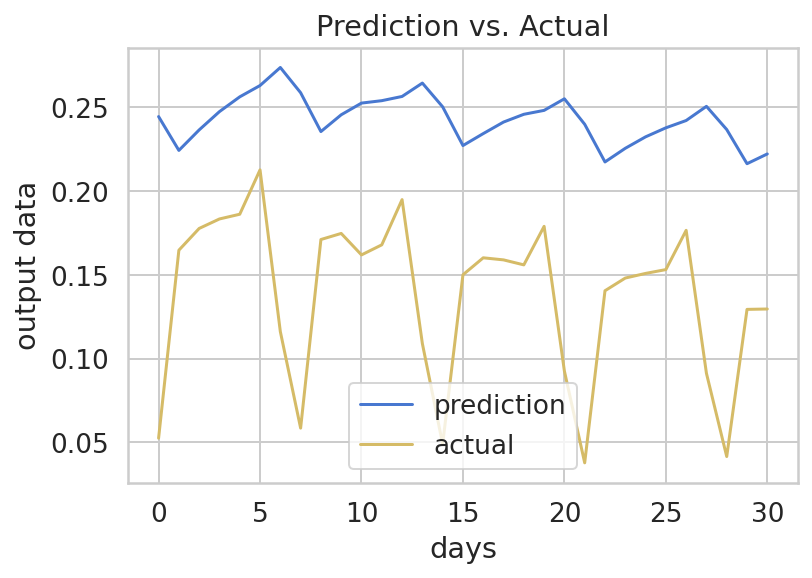

In [ ]:

import matplotlib.pyplot as plt
plt.plot(pre_test_1, 'b-', label = 'prediction')
plt.plot(y_test, 'y-', label = 'actual')

plt.xlabel('days')
plt.ylabel('output data')
plt.title('Prediction vs. Actual')
plt.legend()

In [ ]:
RMSE = round(rmse(pre_test_1, y_test), 4)
MAE = round(mae(pre_test_1, y_test), 4)
MDA = round(mda(pre_test_1, y_test), 4)
print('The RMSE for model with seq = 6 is {0}'.format(RMSE))
print('The MAE for model with seq = 6 is {0}'.format(MAE))
print('The MDA for model with seq = 6 is {0}%'.format(MDA*100))

The RMSE for model with seq = 6 is 0.1167
The MAE for model with seq = 6 is 0.1052
The MDA for model with seq = 6 is 60.0%
